In [39]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

In [40]:
import os
import datetime
from time import time
import torch
import torch.nn as nn
import torch.optim as optim
#from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torch.optim as optim
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

In [41]:
import os
import numpy as np
from PIL import Image
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


def get_dataloaders(dataset_dir, input_size, batch_size, num_workers=4):
    """
    Get train and test dataloaders from the dataset
    """
    def read_pil_image(img_path, height, width): 
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((width, height)))

    def load_all_images(dataset_path, height, width, img_ext='jpg'):
        return np.array([read_pil_image(str(p), height, width) for p in 
                                        Path(dataset_path).rglob("*."+img_ext)]) 

    # Load the data 
    loaded_imgs_train = load_all_images(dataset_dir+'/train/', input_size, input_size)
    
    #calculate mean and standard deviation per channels
    mean = [(loaded_imgs_train[..., i]/255).mean() for i in range(loaded_imgs_train.shape[-1])]
    #print(mean)
    std = [(loaded_imgs_train[..., i]/255).std() for i in range(loaded_imgs_train.shape[-1])]
    #print(std)
    
    #data transforms for trainig and testing
    train_transform = transforms.Compose([
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomRotation(degrees=20),
                        #transforms.RandomAffine(translate=(0, 0.3)),
                        transforms.Resize((input_size, input_size)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean = mean, std = std)])

    test_transform = transforms.Compose([
                        transforms.Resize((input_size, input_size)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean = mean, std = std)])    


     # prepare datasets
    train_data = datasets.ImageFolder(dataset_dir+'train', transform = train_transform)
    test_data = datasets.ImageFolder(dataset_dir+'test', transform = test_transform)

    # prepare dataloaders
    train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_data, batch_size = batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader,train_data,test_data




In [42]:
def accuracy(output, target):
  pred = output.argmax(dim=1)  # get the index of the max log-probability
  return (pred == target).sum().item() / target.numel()  #return the mean accuracy in the batch


In [43]:
def eval_epoch(model, test_loader, criterion, epoch):  #evaluation function after one epoch of training
  
    model.eval()     #eval mode
      
    with torch.no_grad():
        eval_losses = []
        eval_accs = []
        for (inputs, labels) in test_loader:
            #send to GPU device
            inputs, labels = inputs.to(device), labels.to(device)            
            #forward pass
            outputs = model(inputs)  
            #compute the loss in the batch
            eval_loss = criterion(outputs, labels)
            eval_losses.append(eval_loss.item()) #save loss value
            #compute the accuracy in the batch
            eval_acc = 100 * accuracy(outputs, labels) 
            eval_accs.append(eval_acc) #save the accuracy value 
            
        print('Val Epoch: {} \tAverage loss: {:.4f}\tAverage Acc: {:.2f} %'.format(
            epoch, np.mean(eval_losses), np.mean(eval_accs)))
        
        #val_writer.add_scalar('Loss', np.mean(eval_losses), epoch)  #log validation loss for one epoch to Tensorboard
        #val_writer.add_scalar('Acc',  np.mean(eval_accs), epoch)    #log validation accuracy for one epoch to Tensorboard

    return np.mean(eval_losses), np.mean(eval_accs)    

In [44]:
DATASETDIR = '/content/drive/My Drive/MIT_split/'
MODEL_FNAME = 'model.h5'
BATCH_SIZE = 32
EPOCHS = 100
INPUT_SIZE = 64


In [45]:
train_loader, test_loader,train_data,test_data = get_dataloaders(DATASETDIR, INPUT_SIZE, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
from torchvision import datasets, transforms

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self, in_channels=3, kernel_size=3, padding="same"):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1_1 = nn.Conv2d(in_channels, 32, kernel_size, padding=padding)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size, padding=padding)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.bn1_2 = nn.BatchNorm2d(32)
        
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size, padding=padding)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size, padding=padding)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.bn2_2 = nn.BatchNorm2d(64)
        
        self.max_pool = nn.MaxPool2d(2,2)
        
        self.dropout = nn.Dropout(0.3)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.flat = nn.Flatten()
    
        self.fc1 = nn.Linear(64, 8)
        
        #self.logmax = nn.LogSoftmax(dim=1)216, 128)

    def forward(self, x):
        ## Define forward behavior
        x = self.conv1_1(x)
        x = F.elu(self.bn1_1(x))
        x = self.conv1_2(x)
        x = F.elu(self.bn1_2(x))
        x = self.max_pool(x)

        x = self.conv2_1(x)
        x = F.elu(self.bn2_1(x))
        x = self.conv2_2(x)
        x = F.elu(self.bn2_2(x))
        x = self.max_pool(x)
        x = self.dropout(x)

        x = self.global_avg_pool(x)
        x = self.flat(x)


        #x = x.view(-1, 64)

        x = self.fc1(x)
        
        return x

    def get_embedding(self, x):
        return self.forward(x)

### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(
                    epoch, batch_idx, loss, mining_func.num_triplets
                )
            )


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    return accuracies


device = torch.device("cuda")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

batch_size = 256
"""
dataset1 = datasets.MNIST(".", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(".", train=False, transform=transform)
print(type(dataset1))

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=256)"""

model = Net().to(device)
########
PATH = '/content/drive/My Drive/state_dict_model.pt'
#model = models.resnet18(pretrained=True)
#model.fc = nn.Linear(512, 8)
model.load_state_dict(torch.load(PATH))
model.to(device)
cuda = torch.cuda.is_available()
if torch.cuda.is_available():
    model.cuda()
########
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 15

### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="all"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###
criterion = nn.CrossEntropyLoss()   #logsoftmax layer + NLLLoss

for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    val_acc1 = test(train_data, test_data, model, accuracy_calculator)
    #print(type(val_acc1))
    #print(val_acc1['precision_at_1'])
    best_accuracy = 0.0
    val_acc = val_acc1['precision_at_1']
    if best_accuracy < val_acc:
        best_accuracy = val_acc
        torch.save(model.state_dict(), '/content/drive/My Drive' + '/best_params.pt')  #save the model state for best val accuracy

    #val_loss, val_acc = eval_epoch(model, test_loader, criterion, epoch)  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Iteration 0: Loss = 0.18723316490650177, Number of mined triplets = 176
Epoch 1 Iteration 10: Loss = 0.12427689880132675, Number of mined triplets = 139
Epoch 1 Iteration 20: Loss = 0.2354835569858551, Number of mined triplets = 202
Epoch 1 Iteration 30: Loss = 0.1402154564857483, Number of mined triplets = 254
Epoch 1 Iteration 40: Loss = 0.19622206687927246, Number of mined triplets = 53
Epoch 1 Iteration 50: Loss = 0.15258780121803284, Number of mined triplets = 176


100%|██████████| 26/26 [00:05<00:00,  5.18it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8934324659231723
Epoch 2 Iteration 0: Loss = 0.18671949207782745, Number of mined triplets = 211
Epoch 2 Iteration 10: Loss = 0.13441285490989685, Number of mined triplets = 145
Epoch 2 Iteration 20: Loss = 0.12337883561849594, Number of mined triplets = 70
Epoch 2 Iteration 30: Loss = 0.15644243359565735, Number of mined triplets = 129
Epoch 2 Iteration 40: Loss = 0.11913648992776871, Number of mined triplets = 72
Epoch 2 Iteration 50: Loss = 0.1272471696138382, Number of mined triplets = 161


100%|██████████| 26/26 [00:03<00:00,  8.42it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9120198265179678
Epoch 3 Iteration 0: Loss = 0.1857924610376358, Number of mined triplets = 260
Epoch 3 Iteration 10: Loss = 0.09881296753883362, Number of mined triplets = 130
Epoch 3 Iteration 20: Loss = 0.15734034776687622, Number of mined triplets = 35
Epoch 3 Iteration 30: Loss = 0.1689823716878891, Number of mined triplets = 105
Epoch 3 Iteration 40: Loss = 0.13019458949565887, Number of mined triplets = 128
Epoch 3 Iteration 50: Loss = 0.1990254670381546, Number of mined triplets = 125


100%|██████████| 26/26 [00:03<00:00,  8.31it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8971499380421314
Epoch 4 Iteration 0: Loss = 0.15474119782447815, Number of mined triplets = 107
Epoch 4 Iteration 10: Loss = 0.11453064531087875, Number of mined triplets = 36
Epoch 4 Iteration 20: Loss = 0.1625969111919403, Number of mined triplets = 52
Epoch 4 Iteration 30: Loss = 0.15174159407615662, Number of mined triplets = 129
Epoch 4 Iteration 40: Loss = 0.16432388126850128, Number of mined triplets = 204
Epoch 4 Iteration 50: Loss = 0.22090958058834076, Number of mined triplets = 317


100%|██████████| 26/26 [00:03<00:00,  8.37it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9033457249070632
Epoch 5 Iteration 0: Loss = 0.12710410356521606, Number of mined triplets = 39
Epoch 5 Iteration 10: Loss = 0.12462886422872543, Number of mined triplets = 67
Epoch 5 Iteration 20: Loss = 0.23466069996356964, Number of mined triplets = 105
Epoch 5 Iteration 30: Loss = 0.10482778400182724, Number of mined triplets = 70
Epoch 5 Iteration 40: Loss = 0.1764325648546219, Number of mined triplets = 138
Epoch 5 Iteration 50: Loss = 0.09227047860622406, Number of mined triplets = 46


100%|██████████| 26/26 [00:05<00:00,  4.88it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.895910780669145
Epoch 6 Iteration 0: Loss = 0.14321675896644592, Number of mined triplets = 127
Epoch 6 Iteration 10: Loss = 0.1826682686805725, Number of mined triplets = 92
Epoch 6 Iteration 20: Loss = 0.18225273489952087, Number of mined triplets = 94
Epoch 6 Iteration 30: Loss = 0.14635927975177765, Number of mined triplets = 93
Epoch 6 Iteration 40: Loss = 0.11157702654600143, Number of mined triplets = 53
Epoch 6 Iteration 50: Loss = 0.1770925670862198, Number of mined triplets = 113


100%|██████████| 26/26 [00:03<00:00,  6.78it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8983890954151177
Epoch 7 Iteration 0: Loss = 0.14205048978328705, Number of mined triplets = 171
Epoch 7 Iteration 10: Loss = 0.11970151215791702, Number of mined triplets = 75
Epoch 7 Iteration 20: Loss = 0.21904560923576355, Number of mined triplets = 282
Epoch 7 Iteration 30: Loss = 0.128448948264122, Number of mined triplets = 131
Epoch 7 Iteration 40: Loss = 0.1811460256576538, Number of mined triplets = 214
Epoch 7 Iteration 50: Loss = 0.1278148889541626, Number of mined triplets = 89


100%|██████████| 26/26 [00:04<00:00,  5.26it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8847583643122676
Epoch 8 Iteration 0: Loss = 0.13088086247444153, Number of mined triplets = 68
Epoch 8 Iteration 10: Loss = 0.15219803154468536, Number of mined triplets = 208
Epoch 8 Iteration 20: Loss = 0.18423804640769958, Number of mined triplets = 158
Epoch 8 Iteration 30: Loss = 0.13718657195568085, Number of mined triplets = 101
Epoch 8 Iteration 40: Loss = 0.16920995712280273, Number of mined triplets = 156
Epoch 8 Iteration 50: Loss = 0.16357296705245972, Number of mined triplets = 167


100%|██████████| 26/26 [00:03<00:00,  8.26it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8835192069392813
Epoch 9 Iteration 0: Loss = 0.2279270887374878, Number of mined triplets = 184
Epoch 9 Iteration 10: Loss = 0.15843580663204193, Number of mined triplets = 103
Epoch 9 Iteration 20: Loss = 0.08562221378087997, Number of mined triplets = 58
Epoch 9 Iteration 30: Loss = 0.0785115584731102, Number of mined triplets = 18
Epoch 9 Iteration 40: Loss = 0.18665362894535065, Number of mined triplets = 107
Epoch 9 Iteration 50: Loss = 0.1898486614227295, Number of mined triplets = 139


100%|██████████| 26/26 [00:03<00:00,  8.42it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8847583643122676
Epoch 10 Iteration 0: Loss = 0.16501601040363312, Number of mined triplets = 82
Epoch 10 Iteration 10: Loss = 0.20402169227600098, Number of mined triplets = 99
Epoch 10 Iteration 20: Loss = 0.2063158005475998, Number of mined triplets = 122
Epoch 10 Iteration 30: Loss = 0.16682344675064087, Number of mined triplets = 113
Epoch 10 Iteration 40: Loss = 0.15914377570152283, Number of mined triplets = 145
Epoch 10 Iteration 50: Loss = 0.13447265326976776, Number of mined triplets = 76


100%|██████████| 26/26 [00:03<00:00,  8.41it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9008674101610905
Epoch 11 Iteration 0: Loss = 0.06948063522577286, Number of mined triplets = 66
Epoch 11 Iteration 10: Loss = 0.1793757677078247, Number of mined triplets = 67
Epoch 11 Iteration 20: Loss = 0.10005328059196472, Number of mined triplets = 58
Epoch 11 Iteration 30: Loss = 0.16165947914123535, Number of mined triplets = 124
Epoch 11 Iteration 40: Loss = 0.14455057680606842, Number of mined triplets = 71
Epoch 11 Iteration 50: Loss = 0.08383449167013168, Number of mined triplets = 39


100%|██████████| 26/26 [00:03<00:00,  8.51it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9021065675340768
Epoch 12 Iteration 0: Loss = 0.09148750454187393, Number of mined triplets = 34
Epoch 12 Iteration 10: Loss = 0.18662139773368835, Number of mined triplets = 159
Epoch 12 Iteration 20: Loss = 0.21143518388271332, Number of mined triplets = 123
Epoch 12 Iteration 30: Loss = 0.20779448747634888, Number of mined triplets = 156
Epoch 12 Iteration 40: Loss = 0.10816459357738495, Number of mined triplets = 32
Epoch 12 Iteration 50: Loss = 0.12785771489143372, Number of mined triplets = 69


100%|██████████| 26/26 [00:03<00:00,  8.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9045848822800496
Epoch 13 Iteration 0: Loss = 0.1800539791584015, Number of mined triplets = 146
Epoch 13 Iteration 10: Loss = 0.14834852516651154, Number of mined triplets = 112
Epoch 13 Iteration 20: Loss = 0.10193558037281036, Number of mined triplets = 75
Epoch 13 Iteration 30: Loss = 0.10310205817222595, Number of mined triplets = 97
Epoch 13 Iteration 40: Loss = 0.08843646198511124, Number of mined triplets = 72
Epoch 13 Iteration 50: Loss = 0.2203541100025177, Number of mined triplets = 109


100%|██████████| 26/26 [00:03<00:00,  8.48it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8996282527881041
Epoch 14 Iteration 0: Loss = 0.1336415559053421, Number of mined triplets = 114
Epoch 14 Iteration 10: Loss = 0.20327875018119812, Number of mined triplets = 139
Epoch 14 Iteration 20: Loss = 0.15618497133255005, Number of mined triplets = 156
Epoch 14 Iteration 30: Loss = 0.13696706295013428, Number of mined triplets = 57
Epoch 14 Iteration 40: Loss = 0.17300862073898315, Number of mined triplets = 126
Epoch 14 Iteration 50: Loss = 0.1672392338514328, Number of mined triplets = 113


100%|██████████| 26/26 [00:03<00:00,  8.40it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9058240396530359
Epoch 15 Iteration 0: Loss = 0.22630664706230164, Number of mined triplets = 155
Epoch 15 Iteration 10: Loss = 0.18861553072929382, Number of mined triplets = 199
Epoch 15 Iteration 20: Loss = 0.21390672028064728, Number of mined triplets = 138
Epoch 15 Iteration 30: Loss = 0.25723835825920105, Number of mined triplets = 244
Epoch 15 Iteration 40: Loss = 0.12177479267120361, Number of mined triplets = 120
Epoch 15 Iteration 50: Loss = 0.14448726177215576, Number of mined triplets = 147


100%|██████████| 26/26 [00:03<00:00,  8.40it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9120198265179678


In [47]:
PATH = '/content/drive/My Drive/state_dict_model.pt'
#torch.save(model.state_dict(), PATH)

In [48]:
"""
PATH = '/content/drive/My Drive/best_params.pt'
model = Net().to(device)
model.load_state_dict(torch.load(PATH))
model.to(device)"""

'model = Net().to(device)\nmodel.load_state_dict(torch.load(PATH))\nmodel.to(device)'

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


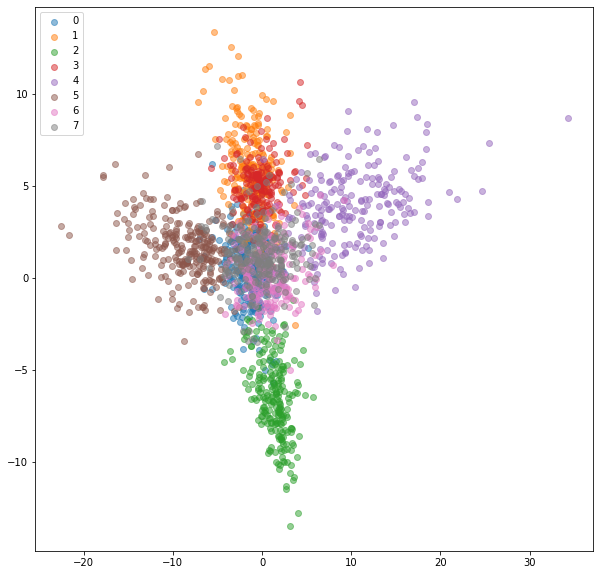

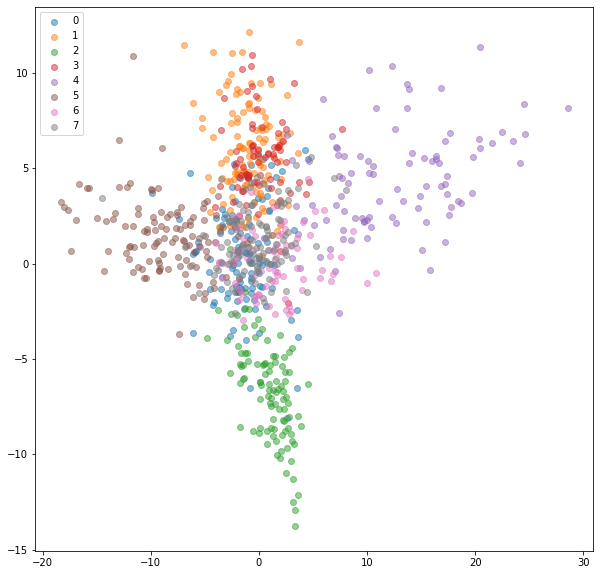

In [55]:
%matplotlib inline
import numpy as np
cuda = torch.cuda.is_available()
import matplotlib
import matplotlib.pyplot as plt

classes = ['0', '1', '2', '3', '4', '5', '6', '7']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
        ]

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(len(classes)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 8))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images.float()).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

"""def extract_embeddings(dataloader, model):
    model_cut = nn.Sequential(*list(model.children())[:-2])
    with torch.no_grad():        
        model.eval()
        embeddings = np.empty((0,2048))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            #print(images.shape)
            #print(model(images.float()).shape)
            #print(model_cut(images.float()).data.cpu().numpy().shape)
            embeddings = np.vstack((embeddings,model_cut(images.float()).data.cpu().numpy().reshape(-1,2048)))
            #print(embeddings.shape)
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels"""

train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lo

score obtained equal to 0.9058240396530359


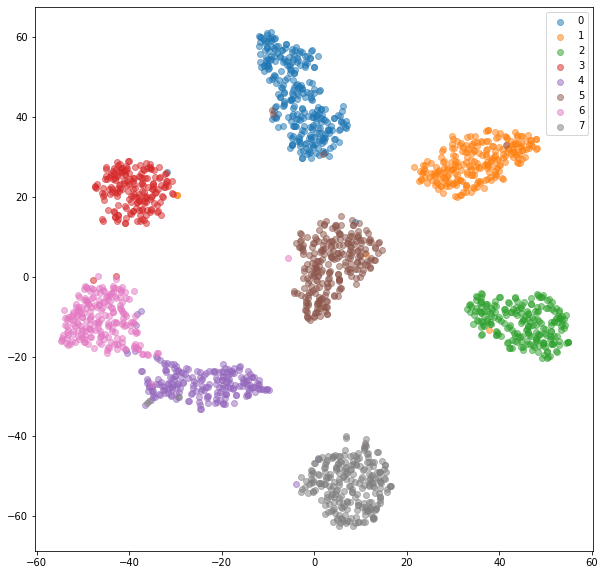

In [56]:


%matplotlib inline
#from plot_emb import plot_embeddings, extract_embeddings
import numpy as np
cuda = torch.cuda.is_available()
import matplotlib
import matplotlib.pyplot as plt

classes = ['0', '1', '2', '3', '4', '5', '6', '7']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
        ]

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(len(classes)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 8))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images.float()).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

"""def extract_embeddings(dataloader, model):
    model_cut = nn.Sequential(*list(model.children())[:-2])
    with torch.no_grad():        
        model.eval()
        embeddings = np.empty((0,2048))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            #print(images.shape)
            #print(model(images.float()).shape)
            #print(model_cut(images.float()).data.cpu().numpy().shape)
            embeddings = np.vstack((embeddings,model_cut(images.float()).data.cpu().numpy().reshape(-1,2048)))
            #print(embeddings.shape)
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels"""

def fit_retrival(embeddings,labels,mode='knn'):
    if mode == 'knn':
        clf = neighbors.KNeighborsClassifier(n_neighbors=8)
        clf.fit(embeddings, labels)
    return clf
def predict_retrival(model,embeddings,labels):
    return model.predict(embeddings),model.score(embeddings,labels)
def plot_TSNE(embeddings):
    from sklearn.manifold import TSNE
    X_embedded = TSNE(n_components=2,
                 init='random').fit_transform(embeddings)
    return  X_embedded

train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)

TSNE_embedding = plot_TSNE(train_embeddings_otl)
retrival_module = fit_retrival(train_embeddings_otl,train_labels_otl,mode='knn')

plot_embeddings(TSNE_embedding, train_labels_otl)


test_embeddings_otl, test_labels_otl = extract_embeddings(test_loader, model)
labels,score = predict_retrival(retrival_module,test_embeddings_otl, test_labels_otl)
print('score obtained equal to {}'.format(score))

